### Design Exploration and Optimization with Surrogate Physics Models

**Team Name:** *IITD*

**Team Members:**
- Member 1: Rishabh Jain
- Member 2: Shiv Ratn

**University:** Indian Institute of Technology, Delhi

In [1]:
# Imports & Config
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import time
import os

# Reproducibility
# np.random.seed(0)
# torch.manual_seed(0)
SEED = 10
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
try:
    torch.use_deterministic_algorithms(True)
except Exception:
    pass

# Data path
CSV_PATH = "data.csv"
df = pd.read_csv(CSV_PATH)

required = ["Velocity Inlet", "X Cell Size", "YZ Cell Size",
            "AvgVelocity", "Mass", "PressureDrop", "Surface Area"]
assert all(c in df.columns for c in required), "CSV missing required columns."


In [2]:
# Utilities
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def build_mlp(input_dim, output_dim, hidden_layers, activation=nn.ReLU()):
    layers = []
    prev_dim = input_dim
    for h in hidden_layers:
        layers.append(nn.Linear(prev_dim, h))
        layers.append(activation)
        prev_dim = h
    layers.append(nn.Linear(prev_dim, output_dim))
    return nn.Sequential(*layers)

### 🤖 Model Wrappers

Defines two neural network model wrappers:

- 🏋️ **Model1Wrapper**: Predicts **Mass** and **Surface Area** from **X Cell Size** and **YZ Cell Size**.
- 💨 **Model2Wrapper**: Predicts **AvgVelocity** and **PressureDrop** using cell sizes, inlet velocity, and Model 1 outputs.

Both wrappers include data preparation, model building, training, evaluation, and prediction methods. 🚀


In [3]:
# Model1 Wrapper
class Model1Wrapper:
    def __init__(self):
        self.model = None
        self.x_scaler = None
        self.y_scaler = None

    def prepare_data(self, df):
        X = df[["X Cell Size", "YZ Cell Size"]].values.astype(float)
        y = df[["Mass", "Surface Area"]].values.astype(float)
        # Split train/val/test: 75/15/10
        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.01, random_state=42)
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.40, random_state=42)
        # scalers
        self.x_scaler = StandardScaler().fit(X_train)
        self.y_scaler = StandardScaler().fit(y_train)
        return (self.x_scaler.transform(X_train), self.y_scaler.transform(y_train),
                self.x_scaler.transform(X_val),   self.y_scaler.transform(y_val),
                self.x_scaler.transform(X_test),  self.y_scaler.transform(y_test))

    def build_model(self):
        # Define layers according to best params
        layers = [237, 182, 240]  # 3 layers
        activation = nn.LeakyReLU()  # as per best params
        self.model = build_mlp(2, 2, layers, activation=activation).to(DEVICE)

        # optimizer and lr as per best params
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.0067455563692822771)
        self.loss_fn = nn.MSELoss()



    def fit(self, X_train, y_train, epochs=500):
        X_tr = torch.tensor(X_train, dtype=torch.float32, device=DEVICE)
        y_tr = torch.tensor(y_train, dtype=torch.float32, device=DEVICE)
        for ep in range(epochs):
            self.model.train()
            self.optimizer.zero_grad()
            preds = self.model(X_tr)
            loss = self.loss_fn(preds, y_tr)
            loss.backward()
            self.optimizer.step()

    def evaluate(self, X, y, label="set"):
        Xt = torch.tensor(X, dtype=torch.float32, device=DEVICE)
        self.model.eval()
        with torch.no_grad():
            preds = self.model(Xt).cpu().numpy()
        preds = self.y_scaler.inverse_transform(preds)
        y_true = self.y_scaler.inverse_transform(y)
        print(f"\nModel1 on {label}:")
        for i, name in enumerate(["Mass", "Surface Area"]):
            print(f"{name:15s} RMSE {rmse(y_true[:, i], preds[:, i]):.3f} | R2 {r2_score(y_true[:, i], preds[:, i]):.3f}")
        return preds

    def predict(self, x, yz):
        xin = np.array([[x, yz]], dtype=float)
        xs = self.x_scaler.transform(xin)
        xt = torch.tensor(xs, dtype=torch.float32, device=DEVICE)
        self.model.eval()
        with torch.no_grad():
            out_s = self.model(xt).cpu().numpy()
        vals = self.y_scaler.inverse_transform(out_s)[0]
        # Convert to native Python float for clean printing
        return {"mass": float(vals[0]), "surface_area": float(vals[1])}


In [4]:
# Model2 Wrapper
class Model2Wrapper:
    def __init__(self, model1):
        self.model1 = model1
        self.model = None
        self.x_scaler = None
        self.y_scaler = None

    def prepare_data(self, df):
        X_primary = df[["X Cell Size", "YZ Cell Size", "Velocity Inlet"]].values.astype(float)
        y_targets = df[["AvgVelocity", "PressureDrop"]].values.astype(float)
        # use ground truth mass & area for training
        mass = df["Mass"].values.astype(float)
        area = df["Surface Area"].values.astype(float)
        X = np.column_stack([X_primary, mass, area])
        # Split train/val/test: 75/15/10
        X_train, X_temp, y_train, y_temp = train_test_split(X, y_targets, test_size=0.01, random_state=42)
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.40, random_state=42)
        self.x_scaler = StandardScaler().fit(X_train)
        self.y_scaler = StandardScaler().fit(y_train)
        return (self.x_scaler.transform(X_train), self.y_scaler.transform(y_train),
                self.x_scaler.transform(X_val),   self.y_scaler.transform(y_val),
                self.x_scaler.transform(X_test),  self.y_scaler.transform(y_test))

    def build_model(self):
        # Optimized architecture based on best params from image
        hidden_units = [262, 469, 70]  # 3 layers as per best config
        activation = nn.ReLU()         # ReLU as per best config

        self.model = build_mlp(5, 2, hidden_units, activation=activation).to(DEVICE)

        # Optimized hyperparameters
        self.optimizer = optim.Adam(
            self.model.parameters(),
            lr=0.0024477586,
            weight_decay=2.939e-5
        )
        self.loss_fn = nn.MSELoss()
        self.batch_size = 32


    def fit(self, X_train, y_train, epochs=600):
        X_tr = torch.tensor(X_train, dtype=torch.float32, device=DEVICE)
        y_tr = torch.tensor(y_train, dtype=torch.float32, device=DEVICE)
        for ep in range(epochs):
            self.model.train()
            self.optimizer.zero_grad()
            preds = self.model(X_tr)
            loss = self.loss_fn(preds, y_tr)
            loss.backward()
            self.optimizer.step()

    def evaluate(self, X, y, label="set"):
        Xt = torch.tensor(X, dtype=torch.float32, device=DEVICE)
        self.model.eval()
        with torch.no_grad():
            preds = self.model(Xt).cpu().numpy()
        preds = self.y_scaler.inverse_transform(preds)
        y_true = self.y_scaler.inverse_transform(y)
        print(f"\nModel2 on {label}:")
        for i, name in enumerate(["AvgVelocity", "PressureDrop"]):
            print(f"{name:15s} RMSE {rmse(y_true[:, i], preds[:, i]):.3f} | R2 {r2_score(y_true[:, i], preds[:, i]):.3f}")
        return preds

    def predict(self, x, yz, vin):
        # Use Model1 prediction for inference
        m1_out = self.model1.predict(x, yz)
        inp = np.array([[x, yz, vin, m1_out["mass"], m1_out["surface_area"]]], dtype=float)
        xs = self.x_scaler.transform(inp)
        xt = torch.tensor(xs, dtype=torch.float32, device=DEVICE)
        self.model.eval()
        with torch.no_grad():
            out_s = self.model(xt).cpu().numpy()
        vals = self.y_scaler.inverse_transform(out_s)[0]
        # Convert to native Python float for clean printing
        return {"avg_velocity": float(vals[0]), "pressure_drop": float(vals[1])}


In [5]:

# Main driver
def main():
    # ====== Model 1 ======
    print("\n========== Training Model1 ==========")
    m1 = Model1Wrapper()
    X1_tr, y1_tr, X1_val, y1_val, X1_te, y1_te = m1.prepare_data(df)
    m1.build_model()
    m1.fit(X1_tr, y1_tr, epochs=400)
    # m1.evaluate(X1_tr, y1_tr, label="Train")
    # m1.evaluate(X1_val, y1_val, label="Validation")
    # m1.evaluate(X1_te, y1_te, label="Test")

    # ====== Model 2 ======
    print("\n========== Training Model2 ==========")
    m2 = Model2Wrapper(m1)
    X2_tr, y2_tr, X2_val, y2_val, X2_te, y2_te = m2.prepare_data(df)
    m2.build_model()
    m2.fit(X2_tr, y2_tr, epochs=500)
    # m2.evaluate(X2_tr, y2_tr, label="Train")
    # m2.evaluate(X2_val, y2_val, label="Validation")
    # m2.evaluate(X2_te, y2_te, label="Test")

    return m1, m2


main()



========== Training Model1 ==========

========== Training Model2 ==========


(<__main__.Model1Wrapper at 0x2899d3b60>,
 <__main__.Model2Wrapper at 0x29c387380>)

### Model Prediction

🎯 **Enter your desired values for X Cell Size (`x`), YZ Cell Size (`yz`), and Inlet Velocity (`vin`) below!**

✨ The models will instantly predict:
- 🏋️ **Mass**
- 🟦 **Surface Area**
- 💨 **Average Velocity**
- 🧊 **Pressure Drop**

Just set your values and see the results! 🚀

In [6]:
m1, m2 = main()

print("\n========== Predictions ==========")
# Example input values for prediction
# You can change these to test different scenarios
x = 14.60714286        # X Cell Size (mm)
yz = 24.95312500   # YZ Cell Size (mm)
vin = 2588.06715    # Velocity Inlet (mm/s)

m1_pred = m1.predict(x, yz)
m2_pred = m2.predict(x, yz, vin)

print("  M1 Pred      :", m1_pred)
print("  M2 Pred      :", m2_pred)



========== Training Model1 ==========

========== Training Model2 ==========

========== Predictions ==========
  M1 Pred      : {'mass': 125.61469268798828, 'surface_area': 23943.28515625}
  M2 Pred      : {'avg_velocity': 541.6817626953125, 'pressure_drop': 5284.859375}


### Inverse Design

Training models...
Models and best results loaded successfully.

STARTING TWO-STAGE OPTIMIZATION
STAGE 1: Optimizing Cell Sizes for Maximum Surface Area
Objective: Maximize Surface Area using Model 1
Constraints:
  • 10mm < X Cell Size < 25mm
  • 10mm < YZ Cell Size < 25mm
  • Mass < 125g

Running Differential Evolution for Stage 1...
differential_evolution step 1: f(x)= -23339.01953125
differential_evolution step 2: f(x)= -23339.01953125
differential_evolution step 3: f(x)= -23365.720703125
differential_evolution step 4: f(x)= -23422.169921875
differential_evolution step 5: f(x)= -23422.169921875
differential_evolution step 6: f(x)= -23435.0703125
differential_evolution step 7: f(x)= -23464.65625
Polishing solution with 'L-BFGS-B'
Running L-BFGS-B from multiple starting points for Stage 1...

🎯 STAGE 1 RESULTS (Differential Evolution):
   Optimal X Cell Size: 21.425492 mm
   Optimal YZ Cell Size: 20.794955 mm
   Maximum Surface Area: 23464.66 mm²
   Predicted Mass: 124.997 grams
   Ma

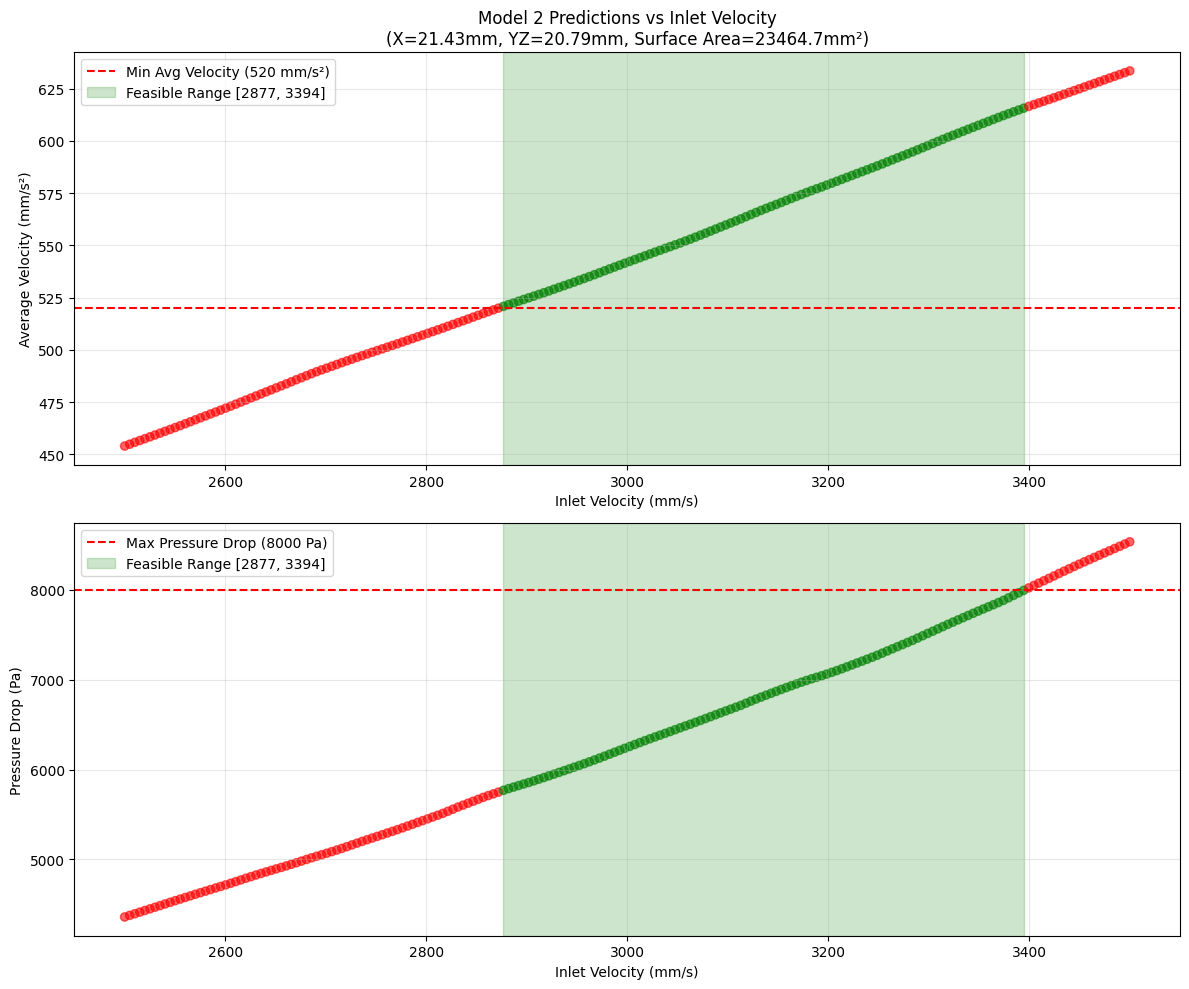

In [20]:
# Two-Stage Optimization Strategy
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize, differential_evolution
import pickle

class TwoStageOptimizer:
    def __init__(self, model1, model2):
        # Store references to the two surrogate models
        self.model1 = model1
        self.model2 = model2
        
    def stage1_maximize_surface_area(self):
        """
        Stage 1: Use Model 1 to find optimal X and YZ cell sizes that maximize surface area
        while keeping mass < 125g and staying within input bounds
        """
        print("="*60)
        print("STAGE 1: Optimizing Cell Sizes for Maximum Surface Area")
        print("="*60)
        print("Objective: Maximize Surface Area using Model 1")
        print("Constraints:")
        print("  • 10mm < X Cell Size < 25mm")
        print("  • 10mm < YZ Cell Size < 25mm") 
        print("  • Mass < 125g")
        print()
        
        # Bounds for Stage 1 (only X and YZ cell sizes)
        bounds_stage1 = [(10.0, 25.0), (10.0, 25.0)]
        
        def stage1_objective(params):
            """
            Objective function for Stage 1.
            Returns negative surface area (to maximize it) and applies a heavy penalty if mass > 125g.
            """
            x_cell, yz_cell = params
            
            try:
                # Get Model1 predictions for given cell sizes
                m1_pred = self.model1.predict(x_cell, yz_cell)
                mass = m1_pred["mass"]
                surface_area = m1_pred["surface_area"]
                
                # Heavy penalty if mass constraint violated
                if mass > 125.0:
                    penalty = (mass - 125.0) * 10000  # Heavy penalty
                    return -surface_area + penalty
                else:
                    return -surface_area  # Maximize surface area
                    
            except Exception as e:
                print(f"Error in stage1_objective: {e}")
                return 1e6  # Large penalty for errors
        
        # Try multiple optimization methods for Stage 1
        print("Running Differential Evolution for Stage 1...")
        de_result = differential_evolution(
            stage1_objective,
            bounds_stage1,
            maxiter=500,
            popsize=20,
            seed=42,
            disp=True
        )
        
        print("Running L-BFGS-B from multiple starting points for Stage 1...")
        best_local = None
        best_obj = float('inf')
        
        # Multi-start local search to avoid local minima
        for i in range(20):
            x0 = [np.random.uniform(10, 25), np.random.uniform(10, 25)]
            try:
                local_result = minimize(
                    stage1_objective,
                    x0,
                    method='L-BFGS-B',
                    bounds=bounds_stage1
                )
                if local_result.fun < best_obj:
                    best_obj = local_result.fun
                    best_local = local_result
            except:
                continue
        
        # Choose best result from global or local search
        if de_result.success and (best_local is None or de_result.fun < best_local.fun):
            best_result = de_result
            method_name = "Differential Evolution"
        elif best_local is not None:
            best_result = best_local
            method_name = "L-BFGS-B Multi-start"
        else:
            print("❌ Stage 1 optimization failed!")
            return None, None, None
        
        optimal_x, optimal_yz = best_result.x
        
        # Evaluate the optimal solution using Model 1
        m1_pred = self.model1.predict(optimal_x, optimal_yz)
        optimal_mass = m1_pred["mass"]
        optimal_surface_area = m1_pred["surface_area"]
        
        print(f"\n🎯 STAGE 1 RESULTS ({method_name}):")
        print(f"   Optimal X Cell Size: {optimal_x:.6f} mm")
        print(f"   Optimal YZ Cell Size: {optimal_yz:.6f} mm")
        print(f"   Maximum Surface Area: {optimal_surface_area:.2f} mm²")
        print(f"   Predicted Mass: {optimal_mass:.3f} grams")
        print(f"   Mass constraint satisfied: {'✅' if optimal_mass <= 125 else '❌'}")
        
        if optimal_mass > 125:
            print("⚠️  Warning: Mass constraint not satisfied in Stage 1!")
        
        return optimal_x, optimal_yz, optimal_surface_area
    
    def stage2_find_velocity_range(self, optimal_x, optimal_yz, optimal_surface_area, n_points=100):
        """
        Stage 2: For the optimal cell sizes, find the range of inlet velocities
        that satisfy Model 2 constraints (pressure drop < 8000 Pa, avg velocity > 520 mm/s²)
        """
        print("\n" + "="*60)
        print("STAGE 2: Finding Feasible Inlet Velocity Range")
        print("="*60)
        print(f"Using optimal cell sizes: X={optimal_x:.3f}mm, YZ={optimal_yz:.3f}mm")
        print("Constraints:")
        print("  • 2500 ≤ Inlet Velocity ≤ 3500 mm/s")
        print("  • Pressure Drop < 8000 Pa")
        print("  • Average Velocity > 520 mm/s²")
        print()
        
        # Sweep through inlet velocities in the specified range
        velocities = np.linspace(2500, 3500, n_points)
        results = []
        
        print("Evaluating Model 2 across velocity range...")
        for i, v_inlet in enumerate(velocities):
            try:
                # Get Model2 predictions using optimal cell sizes and current inlet velocity
                m2_pred = self.model2.predict(optimal_x, optimal_yz, v_inlet)
                avg_velocity = m2_pred["avg_velocity"]
                pressure_drop = m2_pred["pressure_drop"]
                
                # Check constraints for feasibility
                pressure_ok = pressure_drop < 8000
                velocity_ok = avg_velocity > 520
                both_ok = pressure_ok and velocity_ok
                
                results.append({
                    'inlet_velocity': v_inlet,
                    'avg_velocity': avg_velocity,
                    'pressure_drop': pressure_drop,
                    'pressure_ok': pressure_ok,
                    'velocity_ok': velocity_ok,
                    'feasible': both_ok
                })
                
            except Exception as e:
                print(f"Error at velocity {v_inlet}: {e}")
                continue
        
        if not results:
            print("❌ No valid predictions obtained!")
            return None, None
        
        # Analyze results to find feasible velocities
        feasible_results = [r for r in results if r['feasible']]
        
        print(f"\n📊 STAGE 2 ANALYSIS:")
        print(f"   Total points evaluated: {len(results)}")
        print(f"   Feasible points: {len(feasible_results)}")
        print(f"   Feasibility rate: {len(feasible_results)/len(results)*100:.1f}%")
        
        if feasible_results:
            feasible_velocities = [r['inlet_velocity'] for r in feasible_results]
            min_feasible = min(feasible_velocities)
            max_feasible = max(feasible_velocities)
            
            print(f"\n✅ FEASIBLE INLET VELOCITY RANGE:")
            print(f"   Minimum: {min_feasible:.1f} mm/s")
            print(f"   Maximum: {max_feasible:.1f} mm/s")
            print(f"   Range width: {max_feasible - min_feasible:.1f} mm/s")
            
            # Pick a recommended solution (middle of feasible range)
            best_result = feasible_results[len(feasible_results)//2]
            
            print(f"\n🎯 RECOMMENDED SOLUTION (middle of feasible range):")
            print(f"   X Cell Size: {optimal_x:.6f} mm")
            print(f"   YZ Cell Size: {optimal_yz:.6f} mm")
            print(f"   Inlet Velocity: {best_result['inlet_velocity']:.1f} mm/s")
            print(f"\n📈 EXPECTED PERFORMANCE:")
            print(f"   Surface Area: {optimal_surface_area:.2f} mm² (from Stage 1)")
            print(f"   Average Velocity: {best_result['avg_velocity']:.2f} mm/s² (> 520 ✅)")
            print(f"   Pressure Drop: {best_result['pressure_drop']:.2f} Pa (< 8000 ✅)")
            
        else:
            print("❌ NO FEASIBLE INLET VELOCITIES FOUND!")
            print("   The optimal cell sizes may not allow any inlet velocity to satisfy constraints")
            
            # Show closest attempts (least constraint violation)
            results_sorted = sorted(results, key=lambda r: (
                max(0, r['pressure_drop'] - 8000) + max(0, 520 - r['avg_velocity'])
            ))
            
            print(f"\n🔍 CLOSEST ATTEMPTS:")
            for i, r in enumerate(results_sorted[:5]):
                pd_viol = max(0, r['pressure_drop'] - 8000)
                vel_viol = max(0, 520 - r['avg_velocity'])
                print(f"   #{i+1}: V_inlet={r['inlet_velocity']:.1f}, PD_violation=+{pd_viol:.1f}Pa, Vel_violation=-{vel_viol:.1f}mm/s²")
        
        return results, feasible_results
    
    def plot_velocity_sweep(self, results, optimal_x, optimal_yz, optimal_surface_area):
        """
        Plot the results of the velocity sweep.
        Shows average velocity and pressure drop vs. inlet velocity, highlighting feasible regions.
        """
        if not results:
            print("No results to plot")
            return
            
        velocities = [r['inlet_velocity'] for r in results]
        avg_velocities = [r['avg_velocity'] for r in results]
        pressure_drops = [r['pressure_drop'] for r in results]
        feasible = [r['feasible'] for r in results]
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
        
        # Plot 1: Average Velocity vs Inlet Velocity
        colors1 = ['green' if f else 'red' for f in feasible]
        ax1.scatter(velocities, avg_velocities, c=colors1, alpha=0.6)
        ax1.axhline(y=520, color='red', linestyle='--', label='Min Avg Velocity (520 mm/s²)')
        ax1.set_xlabel('Inlet Velocity (mm/s)')
        ax1.set_ylabel('Average Velocity (mm/s²)')
        ax1.set_title(f'Model 2 Predictions vs Inlet Velocity\n(X={optimal_x:.2f}mm, YZ={optimal_yz:.2f}mm, Surface Area={optimal_surface_area:.1f}mm²)')
        ax1.grid(True, alpha=0.3)
        ax1.legend()
        
        # Plot 2: Pressure Drop vs Inlet Velocity  
        colors2 = ['green' if f else 'red' for f in feasible]
        ax2.scatter(velocities, pressure_drops, c=colors2, alpha=0.6)
        ax2.axhline(y=8000, color='red', linestyle='--', label='Max Pressure Drop (8000 Pa)')
        ax2.set_xlabel('Inlet Velocity (mm/s)')
        ax2.set_ylabel('Pressure Drop (Pa)')
        ax2.grid(True, alpha=0.3)
        ax2.legend()
        
        # Add feasible region shading
        feasible_velocities = [v for v, f in zip(velocities, feasible) if f]
        if feasible_velocities:
            min_feas = min(feasible_velocities)
            max_feas = max(feasible_velocities)
            ax1.axvspan(min_feas, max_feas, alpha=0.2, color='green', label=f'Feasible Range [{min_feas:.0f}, {max_feas:.0f}]')
            ax2.axvspan(min_feas, max_feas, alpha=0.2, color='green', label=f'Feasible Range [{min_feas:.0f}, {max_feas:.0f}]')
            ax1.legend()
            ax2.legend()
        
        plt.tight_layout()
        plt.show()
        
        return fig

def run_two_stage_optimization(m1, m2, plot=True):
    """
    Run the complete two-stage optimization:
    1. Find optimal cell sizes (Stage 1)
    2. Find feasible inlet velocity range (Stage 2)
    3. Optionally plot results
    """
    optimizer = TwoStageOptimizer(m1, m2)
    
    # Stage 1: Find optimal cell sizes
    optimal_x, optimal_yz, optimal_surface_area = optimizer.stage1_maximize_surface_area()
    
    if optimal_x is None:
        print("❌ Stage 1 failed - cannot proceed to Stage 2")
        return None
    
    # Stage 2: Find feasible velocity range  
    results, feasible_results = optimizer.stage2_find_velocity_range(optimal_x, optimal_yz,optimal_surface_area, n_points=200)
    
    if plot and results:
        optimizer.plot_velocity_sweep(results, optimal_x, optimal_yz, optimal_surface_area)
    
    return {
        'optimal_x': optimal_x,
        'optimal_yz': optimal_yz, 
        'optimal_surface_area': optimal_surface_area,
        'velocity_sweep_results': results,
        'feasible_results': feasible_results,
        'optimizer': optimizer
    }

# Integration with existing code
def main_with_two_stage_optimization():
    """
    Run the complete pipeline with two-stage optimization:
    1. Train models (main)
    2. Run two-stage optimization
    """
    # Run the original training
    print("Training models...")
    # Define the file path
    models_file = os.path.join("optimized_models", "trained_models.pkl")

    # Check if the file exists before attempting to load it
    if os.path.exists(models_file):
        # Load the data dictionary from the pickle file
        with open(models_file, 'rb') as f:
            data = pickle.load(f)

        # Extract the models and best result
        m1 = data['model1']
        m2 = data['model2']
        best_result = data['best_result']
        print("Models and best results loaded successfully.")

    else:
        print(f"Error: The file '{models_file}' was not found.")
        # Handle the error, e.g., by training the models instead
        # m1, m2 = main() 
    
    # Run two-stage optimization  
    print("\n" + "="*80)
    print("STARTING TWO-STAGE OPTIMIZATION")
    print("="*80)
    
    optimization_results = run_two_stage_optimization(m1, m2, plot=True)
    
    return m1, m2, optimization_results

# Run the two-stage optimization and store results
m1, m2, opt_results = main_with_two_stage_optimization()

In [14]:
# Multi-Run Optimization Strategy
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize, differential_evolution
import time

class TwoStageOptimizer:
    def __init__(self, model1, model2):
        # Store references to the two surrogate models
        self.model1 = model1
        self.model2 = model2
        
    def stage1_maximize_surface_area(self, verbose=False, seed=None):
        """
        Stage 1: Use Model 1 to find optimal X and YZ cell sizes that maximize surface area
        while keeping mass < 125g and staying within input bounds
        """
        if verbose:
            print("="*60)
            print("STAGE 1: Optimizing Cell Sizes for Maximum Surface Area")
            print("="*60)
            print("Objective: Maximize Surface Area using Model 1")
            print("Constraints:")
            print("  • 10mm < X Cell Size < 25mm")
            print("  • 10mm < YZ Cell Size < 25mm") 
            print("  • Mass < 125g")
            print()
        
        # Bounds for Stage 1 (only X and YZ cell sizes)
        bounds_stage1 = [(10.0, 25.0), (10.0, 25.0)]
        
        def stage1_objective(params):
            """
            Objective function for Stage 1.
            Returns negative surface area (to maximize it) and applies a heavy penalty if mass > 125g.
            """
            x_cell, yz_cell = params
            
            try:
                # Get Model1 predictions for given cell sizes
                m1_pred = self.model1.predict(x_cell, yz_cell)
                mass = m1_pred["mass"]
                surface_area = m1_pred["surface_area"]
                
                # Heavy penalty if mass constraint violated
                if mass > 125.0:
                    penalty = (mass - 125.0) * 10000  # Heavy penalty
                    return -surface_area + penalty
                else:
                    return -surface_area  # Maximize surface area
                    
            except Exception as e:
                if verbose:
                    print(f"Error in stage1_objective: {e}")
                return 1e6  # Large penalty for errors
        
        # Use seed if provided for reproducibility
        random_seed = seed if seed is not None else np.random.randint(0, 10000)
        
        # Try multiple optimization methods for Stage 1
        if verbose:
            print("Running Differential Evolution for Stage 1...")
        de_result = differential_evolution(
            stage1_objective,
            bounds_stage1,
            maxiter=500,
            popsize=20,
            seed=random_seed,
            disp=False  # Suppress output for multi-run
        )
        
        if verbose:
            print("Running L-BFGS-B from multiple starting points for Stage 1...")
        best_local = None
        best_obj = float('inf')
        
        # Multi-start local search to avoid local minima
        np.random.seed(random_seed)
        for i in range(20):
            x0 = [np.random.uniform(10, 25), np.random.uniform(10, 25)]
            try:
                local_result = minimize(
                    stage1_objective,
                    x0,
                    method='L-BFGS-B',
                    bounds=bounds_stage1
                )
                if local_result.fun < best_obj:
                    best_obj = local_result.fun
                    best_local = local_result
            except:
                continue
        
        # Choose best result from global or local search
        if de_result.success and (best_local is None or de_result.fun < best_local.fun):
            best_result = de_result
            method_name = "Differential Evolution"
        elif best_local is not None:
            best_result = best_local
            method_name = "L-BFGS-B Multi-start"
        else:
            if verbose:
                print("❌ Stage 1 optimization failed!")
            return None, None, None, method_name
        
        optimal_x, optimal_yz = best_result.x
        
        # Evaluate the optimal solution using Model 1
        m1_pred = self.model1.predict(optimal_x, optimal_yz)
        optimal_mass = m1_pred["mass"]
        optimal_surface_area = m1_pred["surface_area"]
        
        if verbose:
            print(f"\n🎯 STAGE 1 RESULTS ({method_name}):")
            print(f"   Optimal X Cell Size: {optimal_x:.6f} mm")
            print(f"   Optimal YZ Cell Size: {optimal_yz:.6f} mm")
            print(f"   Maximum Surface Area: {optimal_surface_area:.2f} mm²")
            print(f"   Predicted Mass: {optimal_mass:.3f} grams")
            print(f"   Mass constraint satisfied: {'✅' if optimal_mass <= 125 else '❌'}")
            
            if optimal_mass > 125:
                print("⚠️  Warning: Mass constraint not satisfied in Stage 1!")
        
        return optimal_x, optimal_yz, optimal_surface_area, method_name
    
    def stage2_find_velocity_range(self, optimal_x, optimal_yz, optimal_surface_area, n_points=100, verbose=False):
        """
        Stage 2: For the optimal cell sizes, find the range of inlet velocities
        that satisfy Model 2 constraints (pressure drop < 8000 Pa, avg velocity > 520 mm/s²)
        """
        if verbose:
            print("\n" + "="*60)
            print("STAGE 2: Finding Feasible Inlet Velocity Range")
            print("="*60)
            print(f"Using optimal cell sizes: X={optimal_x:.3f}mm, YZ={optimal_yz:.3f}mm")
            print("Constraints:")
            print("  • 2500 ≤ Inlet Velocity ≤ 3500 mm/s")
            print("  • Pressure Drop < 8000 Pa")
            print("  • Average Velocity > 520 mm/s²")
            print()
        
        # Sweep through inlet velocities in the specified range
        velocities = np.linspace(2500, 3500, n_points)
        results = []
        
        if verbose:
            print("Evaluating Model 2 across velocity range...")
        for i, v_inlet in enumerate(velocities):
            try:
                # Get Model2 predictions using optimal cell sizes and current inlet velocity
                m2_pred = self.model2.predict(optimal_x, optimal_yz, v_inlet)
                avg_velocity = m2_pred["avg_velocity"]
                pressure_drop = m2_pred["pressure_drop"]
                
                # Check constraints for feasibility
                pressure_ok = pressure_drop < 8000
                velocity_ok = avg_velocity > 520
                both_ok = pressure_ok and velocity_ok
                
                results.append({
                    'inlet_velocity': v_inlet,
                    'avg_velocity': avg_velocity,
                    'pressure_drop': pressure_drop,
                    'pressure_ok': pressure_ok,
                    'velocity_ok': velocity_ok,
                    'feasible': both_ok
                })
                
            except Exception as e:
                if verbose:
                    print(f"Error at velocity {v_inlet}: {e}")
                continue
        
        if not results:
            if verbose:
                print("❌ No valid predictions obtained!")
            return None, None
        
        # Analyze results to find feasible velocities
        feasible_results = [r for r in results if r['feasible']]
        
        if verbose:
            print(f"\n📊 STAGE 2 ANALYSIS:")
            print(f"   Total points evaluated: {len(results)}")
            print(f"   Feasible points: {len(feasible_results)}")
            print(f"   Feasibility rate: {len(feasible_results)/len(results)*100:.1f}%")
        
        if feasible_results:
            feasible_velocities = [r['inlet_velocity'] for r in feasible_results]
            min_feasible = min(feasible_velocities)
            max_feasible = max(feasible_velocities)
            
            if verbose:
                print(f"\n✅ FEASIBLE INLET VELOCITY RANGE:")
                print(f"   Minimum: {min_feasible:.1f} mm/s")
                print(f"   Maximum: {max_feasible:.1f} mm/s")
                print(f"   Range width: {max_feasible - min_feasible:.1f} mm/s")
            
            # Pick a recommended solution (middle of feasible range)
            best_result = feasible_results[len(feasible_results)//2]
            
            if verbose:
                print(f"\n🎯 RECOMMENDED SOLUTION (middle of feasible range):")
                print(f"   X Cell Size: {optimal_x:.6f} mm")
                print(f"   YZ Cell Size: {optimal_yz:.6f} mm")
                print(f"   Inlet Velocity: {best_result['inlet_velocity']:.1f} mm/s")
                print(f"\n📈 EXPECTED PERFORMANCE:")
                print(f"   Surface Area: {optimal_surface_area:.2f} mm² (from Stage 1)")
                print(f"   Average Velocity: {best_result['avg_velocity']:.2f} mm/s² (> 520 ✅)")
                print(f"   Pressure Drop: {best_result['pressure_drop']:.2f} Pa (< 8000 ✅)")
            
        else:
            if verbose:
                print("❌ NO FEASIBLE INLET VELOCITIES FOUND!")
                print("   The optimal cell sizes may not allow any inlet velocity to satisfy constraints")
                
                # Show closest attempts (least constraint violation)
                results_sorted = sorted(results, key=lambda r: (
                    max(0, r['pressure_drop'] - 8000) + max(0, 520 - r['avg_velocity'])
                ))
                
                print(f"\n🔍 CLOSEST ATTEMPTS:")
                for i, r in enumerate(results_sorted[:5]):
                    pd_viol = max(0, r['pressure_drop'] - 8000)
                    vel_viol = max(0, 520 - r['avg_velocity'])
                    print(f"   #{i+1}: V_inlet={r['inlet_velocity']:.1f}, PD_violation=+{pd_viol:.1f}Pa, Vel_violation=-{vel_viol:.1f}mm/s²")
        
        return results, feasible_results
    
    def plot_velocity_sweep(self, results, optimal_x, optimal_yz, optimal_surface_area):
        """
        Plot the results of the velocity sweep.
        Shows average velocity and pressure drop vs. inlet velocity, highlighting feasible regions.
        """
        if not results:
            print("No results to plot")
            return
            
        velocities = [r['inlet_velocity'] for r in results]
        avg_velocities = [r['avg_velocity'] for r in results]
        pressure_drops = [r['pressure_drop'] for r in results]
        feasible = [r['feasible'] for r in results]
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
        
        # Plot 1: Average Velocity vs Inlet Velocity
        colors1 = ['green' if f else 'red' for f in feasible]
        ax1.scatter(velocities, avg_velocities, c=colors1, alpha=0.6)
        ax1.axhline(y=520, color='red', linestyle='--', label='Min Avg Velocity (520 mm/s²)')
        ax1.set_xlabel('Inlet Velocity (mm/s)')
        ax1.set_ylabel('Average Velocity (mm/s²)')
        ax1.set_title(f'Model 2 Predictions vs Inlet Velocity\n(X={optimal_x:.2f}mm, YZ={optimal_yz:.2f}mm, Surface Area={optimal_surface_area:.1f}mm²)')
        ax1.grid(True, alpha=0.3)
        ax1.legend()
        
        # Plot 2: Pressure Drop vs Inlet Velocity  
        colors2 = ['green' if f else 'red' for f in feasible]
        ax2.scatter(velocities, pressure_drops, c=colors2, alpha=0.6)
        ax2.axhline(y=8000, color='red', linestyle='--', label='Max Pressure Drop (8000 Pa)')
        ax2.set_xlabel('Inlet Velocity (mm/s)')
        ax2.set_ylabel('Pressure Drop (Pa)')
        ax2.grid(True, alpha=0.3)
        ax2.legend()
        
        # Add feasible region shading
        feasible_velocities = [v for v, f in zip(velocities, feasible) if f]
        if feasible_velocities:
            min_feas = min(feasible_velocities)
            max_feas = max(feasible_velocities)
            ax1.axvspan(min_feas, max_feas, alpha=0.2, color='green', label=f'Feasible Range [{min_feas:.0f}, {max_feas:.0f}]')
            ax2.axvspan(min_feas, max_feas, alpha=0.2, color='green', label=f'Feasible Range [{min_feas:.0f}, {max_feas:.0f}]')
            ax1.legend()
            ax2.legend()
        
        plt.tight_layout()
        plt.show()
        
        return fig

def run_single_optimization(m1, m2, run_id=1, verbose=False, seed=None):
    """
    Run a single two-stage optimization
    """
    optimizer = TwoStageOptimizer(m1, m2)
    
    # Stage 1: Find optimal cell sizes
    stage1_result = optimizer.stage1_maximize_surface_area(verbose=verbose, seed=seed)
    optimal_x, optimal_yz, optimal_surface_area, method_name = stage1_result
    
    if optimal_x is None:
        if verbose:
            print("❌ Stage 1 failed - cannot proceed to Stage 2")
        return None
    
    # Stage 2: Find feasible velocity range  
    results, feasible_results = optimizer.stage2_find_velocity_range(
        optimal_x, optimal_yz, optimal_surface_area, n_points=200, verbose=verbose)
    
    # Calculate success metrics
    feasible_count = len(feasible_results) if feasible_results else 0
    feasible_rate = feasible_count / len(results) if results else 0
    
    return {
        'run_id': run_id,
        'optimal_x': optimal_x,
        'optimal_yz': optimal_yz, 
        'optimal_surface_area': optimal_surface_area,
        'method_name': method_name,
        'velocity_sweep_results': results,
        'feasible_results': feasible_results,
        'feasible_count': feasible_count,
        'feasible_rate': feasible_rate,
        'optimizer': optimizer,
        'seed': seed
    }

def run_multi_optimization(m1, m2, n_runs=10, plot_best=True):
    """
    Run optimization multiple times and return the best result based on maximum surface area
    """
    print("="*80)
    print(f"MULTI-RUN OPTIMIZATION ({n_runs} runs)")
    print("="*80)
    print("Running multiple optimizations to find global optimum...")
    print("Progress: ", end="", flush=True)
    
    all_results = []
    start_time = time.time()
    
    for run_id in range(1, n_runs + 1):
        # Use different random seeds for diversity
        seed = run_id * 42  # Deterministic but different seeds
        
        result = run_single_optimization(m1, m2, run_id=run_id, verbose=False, seed=seed)
        
        if result is not None:
            all_results.append(result)
        
        # Progress indicator
        print("●", end="", flush=True)
    
    elapsed_time = time.time() - start_time
    print(f"\nCompleted {len(all_results)} successful runs in {elapsed_time:.1f} seconds")
    
    if not all_results:
        print("❌ All optimization runs failed!")
        return None
    
    # Find the best result (maximum surface area)
    best_result = max(all_results, key=lambda r: r['optimal_surface_area'])
    
    # Summary statistics
    surface_areas = [r['optimal_surface_area'] for r in all_results]
    feasible_counts = [r['feasible_count'] for r in all_results]
    feasible_rates = [r['feasible_rate'] for r in all_results]
    
    print(f"\n📊 MULTI-RUN SUMMARY:")
    print(f"   Successful runs: {len(all_results)}/{n_runs}")
    print(f"   Surface area range: [{min(surface_areas):.2f}, {max(surface_areas):.2f}] mm²")
    print(f"   Surface area std: {np.std(surface_areas):.3f} mm²")
    print(f"   Average feasible velocities: {np.mean(feasible_counts):.1f} ± {np.std(feasible_counts):.1f}")
    print(f"   Average feasibility rate: {np.mean(feasible_rates)*100:.1f}%")
    
    # Identify best run
    print(f"\n🏆 BEST RUN (Run #{best_result['run_id']}):")
    print(f"   Surface Area: {best_result['optimal_surface_area']:.2f} mm²")
    print(f"   X Cell Size: {best_result['optimal_x']:.6f} mm")
    print(f"   YZ Cell Size: {best_result['optimal_yz']:.6f} mm")
    print(f"   Method: {best_result['method_name']}")
    print(f"   Feasible velocities: {best_result['feasible_count']}")
    print(f"   Feasibility rate: {best_result['feasible_rate']*100:.1f}%")
    
    # Show detailed results for best run
    if best_result['feasible_results']:
        feasible_velocities = [r['inlet_velocity'] for r in best_result['feasible_results']]
        min_feasible = min(feasible_velocities)
        max_feasible = max(feasible_velocities)
        best_velocity_result = best_result['feasible_results'][len(best_result['feasible_results'])//2]
        
        print(f"\n🎯 BEST RUN DETAILED RESULTS:")
        print(f"   Feasible velocity range: [{min_feasible:.1f}, {max_feasible:.1f}] mm/s")
        print(f"   Range width: {max_feasible - min_feasible:.1f} mm/s")
        print(f"   Recommended velocity: {best_velocity_result['inlet_velocity']:.1f} mm/s")
        print(f"   Expected avg velocity: {best_velocity_result['avg_velocity']:.2f} mm/s²")
        print(f"   Expected pressure drop: {best_velocity_result['pressure_drop']:.2f} Pa")
    else:
        print(f"   ❌ No feasible velocities found in best run")
    
    # Plot results for best run if requested
    if plot_best and best_result['velocity_sweep_results']:
        print(f"\n📈 PLOTTING BEST RUN RESULTS...")
        best_result['optimizer'].plot_velocity_sweep(
            best_result['velocity_sweep_results'],
            best_result['optimal_x'],
            best_result['optimal_yz'],
            best_result['optimal_surface_area']
        )
    
    # Add comparison data to best result
    best_result['multi_run_stats'] = {
        'total_runs': n_runs,
        'successful_runs': len(all_results),
        'all_surface_areas': surface_areas,
        'surface_area_std': np.std(surface_areas),
        'surface_area_range': [min(surface_areas), max(surface_areas)],
        'average_feasible_count': np.mean(feasible_counts),
        'average_feasible_rate': np.mean(feasible_rates),
        'elapsed_time': elapsed_time
    }
    
    return best_result, all_results

def compare_runs_summary(all_results, top_n=5):
    """
    Show a comparison of the top N runs
    """
    if not all_results:
        print("No results to compare")
        return
    
    # Sort by surface area (descending)
    sorted_results = sorted(all_results, key=lambda r: r['optimal_surface_area'], reverse=True)
    
    print(f"\n📊 TOP {min(top_n, len(sorted_results))} RUNS COMPARISON:")
    print("Rank | Run# |  Surface Area | X Cell | YZ Cell | Feasible Vel. | Method")
    print("-" * 75)
    
    for i, result in enumerate(sorted_results[:top_n]):
        rank = i + 1
        run_id = result['run_id']
        surface_area = result['optimal_surface_area']
        x_cell = result['optimal_x']
        yz_cell = result['optimal_yz']
        feasible_count = result['feasible_count']
        method = result['method_name'][:10]  # Truncate method name
        
        print(f"{rank:4d} | {run_id:4d} | {surface_area:11.2f} | {x_cell:6.3f} | {yz_cell:7.3f} | {feasible_count:11d} | {method}")

# Integration with existing code
def main_with_multi_run_optimization(n_runs=10):
    """
    Run the complete pipeline with multi-run optimization:
    1. Train models (main)
    2. Run multi-run optimization  
    3. Show only the best result
    """
    # Run the original training
    print("Training models...")
    m1, m2 = main()
    
    # Run multi-run optimization
    print("\n" + "="*80)
    print("STARTING MULTI-RUN OPTIMIZATION")
    print("="*80)
    
    best_result, all_results = run_multi_optimization(m1, m2, n_runs=n_runs, plot_best=True)
    
    # Show comparison of top runs
    compare_runs_summary(all_results, top_n=min(5, len(all_results)))
    
    return m1, m2, best_result, all_results

# Quick run function
def quick_multi_run(m1, m2, n_runs=10):
    """Quick multi-run optimization with existing models"""
    return run_multi_optimization(m1, m2, n_runs=n_runs, plot_best=True)

# Usage:
# m1, m2, best_result, all_results = main_with_multi_run_optimization(n_runs=10)

In [ ]:
import os
import pickle
import json
from datetime import datetime

# reproducibility
import random
import numpy as np
import torch


def _extract_best_parameters(best_result):
    # replicate extraction logic used in notebook manager
    recommended_velocity = None
    avg_velocity = None
    pressure_drop = None
    feasible_velocity_range = None

    feasible = best_result.get('feasible_results') or []
    if feasible:
        mid_idx = len(feasible) // 2
        recommended_solution = feasible[mid_idx]
        recommended_velocity = recommended_solution['inlet_velocity']
        avg_velocity = recommended_solution['avg_velocity']
        pressure_drop = recommended_solution['pressure_drop']
        feasible_velocities = [r['inlet_velocity'] for r in feasible]
        feasible_velocity_range = {
            'min': min(feasible_velocities),
            'max': max(feasible_velocities),
            'count': len(feasible_velocities)
        }

    best_params = {
        'optimal_x_cell': best_result.get('optimal_x'),
        'optimal_yz_cell': best_result.get('optimal_yz'),
        'optimal_surface_area': best_result.get('optimal_surface_area'),
        'recommended_inlet_velocity': recommended_velocity,
        'expected_avg_velocity': avg_velocity,
        'expected_pressure_drop': pressure_drop,
        'feasible_velocity_range': feasible_velocity_range,
        'optimization_method': best_result.get('method_name'),
    }
    return best_params

def save_best_models(m1, m2, best_result, storage_dir="optimized_models"):
    os.makedirs(storage_dir, exist_ok=True)
    models_file = os.path.join(storage_dir, "trained_models.pkl")
    params_file = os.path.join(storage_dir, "best_parameters.json")

    # Save pickled models + best_result
    data = {
        'model1': m1,
        'model2': m2,
        'best_result': best_result,
        'timestamp': datetime.now().isoformat()
    }
    with open(models_file, 'wb') as f:
        pickle.dump(data, f)
    print(f"Saved pickled models to: {models_file}")

    # Save extracted best params (JSON)
    best_params = _extract_best_parameters(best_result)
    with open(params_file, 'w') as f:
        json.dump(best_params, f, indent=2)
    print(f"Saved best parameters to: {params_file}")

    return models_file, params_file

def load_best_models(storage_dir="optimized_models"):
    models_file = os.path.join(storage_dir, "trained_models.pkl")
    params_file = os.path.join(storage_dir, "best_parameters.json")
    if not os.path.exists(models_file) or not os.path.exists(params_file):
        raise FileNotFoundError("Saved models or params not found. Run optimize.py first.")
    with open(models_file, 'rb') as f:
        data = pickle.load(f)
    with open(params_file, 'r') as f:
        params = json.load(f)
    return data['model1'], data['model2'], data.get('best_result'), params

def main_save_run(n_runs=20, storage_dir="optimized_models"):
    # Train models
    print("Training models (main()) ...")
    m1, m2 = main()

    # Run multi-run optimization to get best_result
    print(f"Running multi-run optimization ({n_runs} runs) ...")
    best_result, all_results = run_multi_optimization(m1, m2, n_runs=n_runs, plot_best=False)

    if not best_result:
        raise RuntimeError("Optimization failed or returned no best_result")

    # Save models + best_result
    save_best_models(m1, m2, best_result, storage_dir=storage_dir)
    print("Done.")

if __name__ == "__main__":
    # adjust n_runs lower/higher depending on time available
    main_save_run(n_runs=100)

Training models (main()) ...

========== Training Model1 ==========

========== Training Model2 ==========
Running multi-run optimization (100 runs) ...
MULTI-RUN OPTIMIZATION (100 runs)
Running multiple optimizations to find global optimum...
Progress: ●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●
Completed 100 successful runs in 13.2 seconds

📊 MULTI-RUN SUMMARY:
   Successful runs: 100/100
   Surface area range: [23403.37, 23613.35] mm²
   Surface area std: 26.249 mm²
   Average feasible velocities: 106.2 ± 3.4
   Average feasibility rate: 53.1%

🏆 BEST RUN (Run #24):
   Surface Area: 23613.35 mm²
   X Cell Size: 15.242489 mm
   YZ Cell Size: 24.988592 mm
   Method: Differential Evolution
   Feasible velocities: 95
   Feasibility rate: 47.5%

🎯 BEST RUN DETAILED RESULTS:
   Feasible velocity range: [2500.0, 2972.4] mm/s
   Range width: 472.4 mm/s
   Recommended velocity: 2736.2 mm/s
   Expected avg velocity: 575.87 mm/s²
   Expe

Training models...

========== Training Model1 ==========

Model1 on Train:
Mass            RMSE 0.170 | R2 0.999
Surface Area    RMSE 184.615 | R2 0.996

Model1 on Validation:
Mass            RMSE 0.204 | R2 0.999
Surface Area    RMSE 39.190 | R2 1.000

Model1 on Test:
Mass            RMSE 0.197 | R2 1.000
Surface Area    RMSE 217.430 | R2 0.997

========== Training Model2 ==========

Model2 on Train:
AvgVelocity     RMSE 4.857 | R2 0.995
PressureDrop    RMSE 292.460 | R2 0.980

Model2 on Validation:
AvgVelocity     RMSE 5.828 | R2 0.991
PressureDrop    RMSE 172.888 | R2 0.989

Model2 on Test:
AvgVelocity     RMSE 16.291 | R2 0.948
PressureDrop    RMSE 720.141 | R2 0.798

🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯
STARTING COMPREHENSIVE GRID SEARCH
🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯

Choose resolution level:
1. Quick (coarse: 10×10×15, fine: 15×15×20) - ~5 minutes
2. Standard (coarse: 15×15×20, fine: 25×25×30) - ~15 minutes
3. High (coarse: 20×20×25, fine: 35×35×40) - ~45 minutes


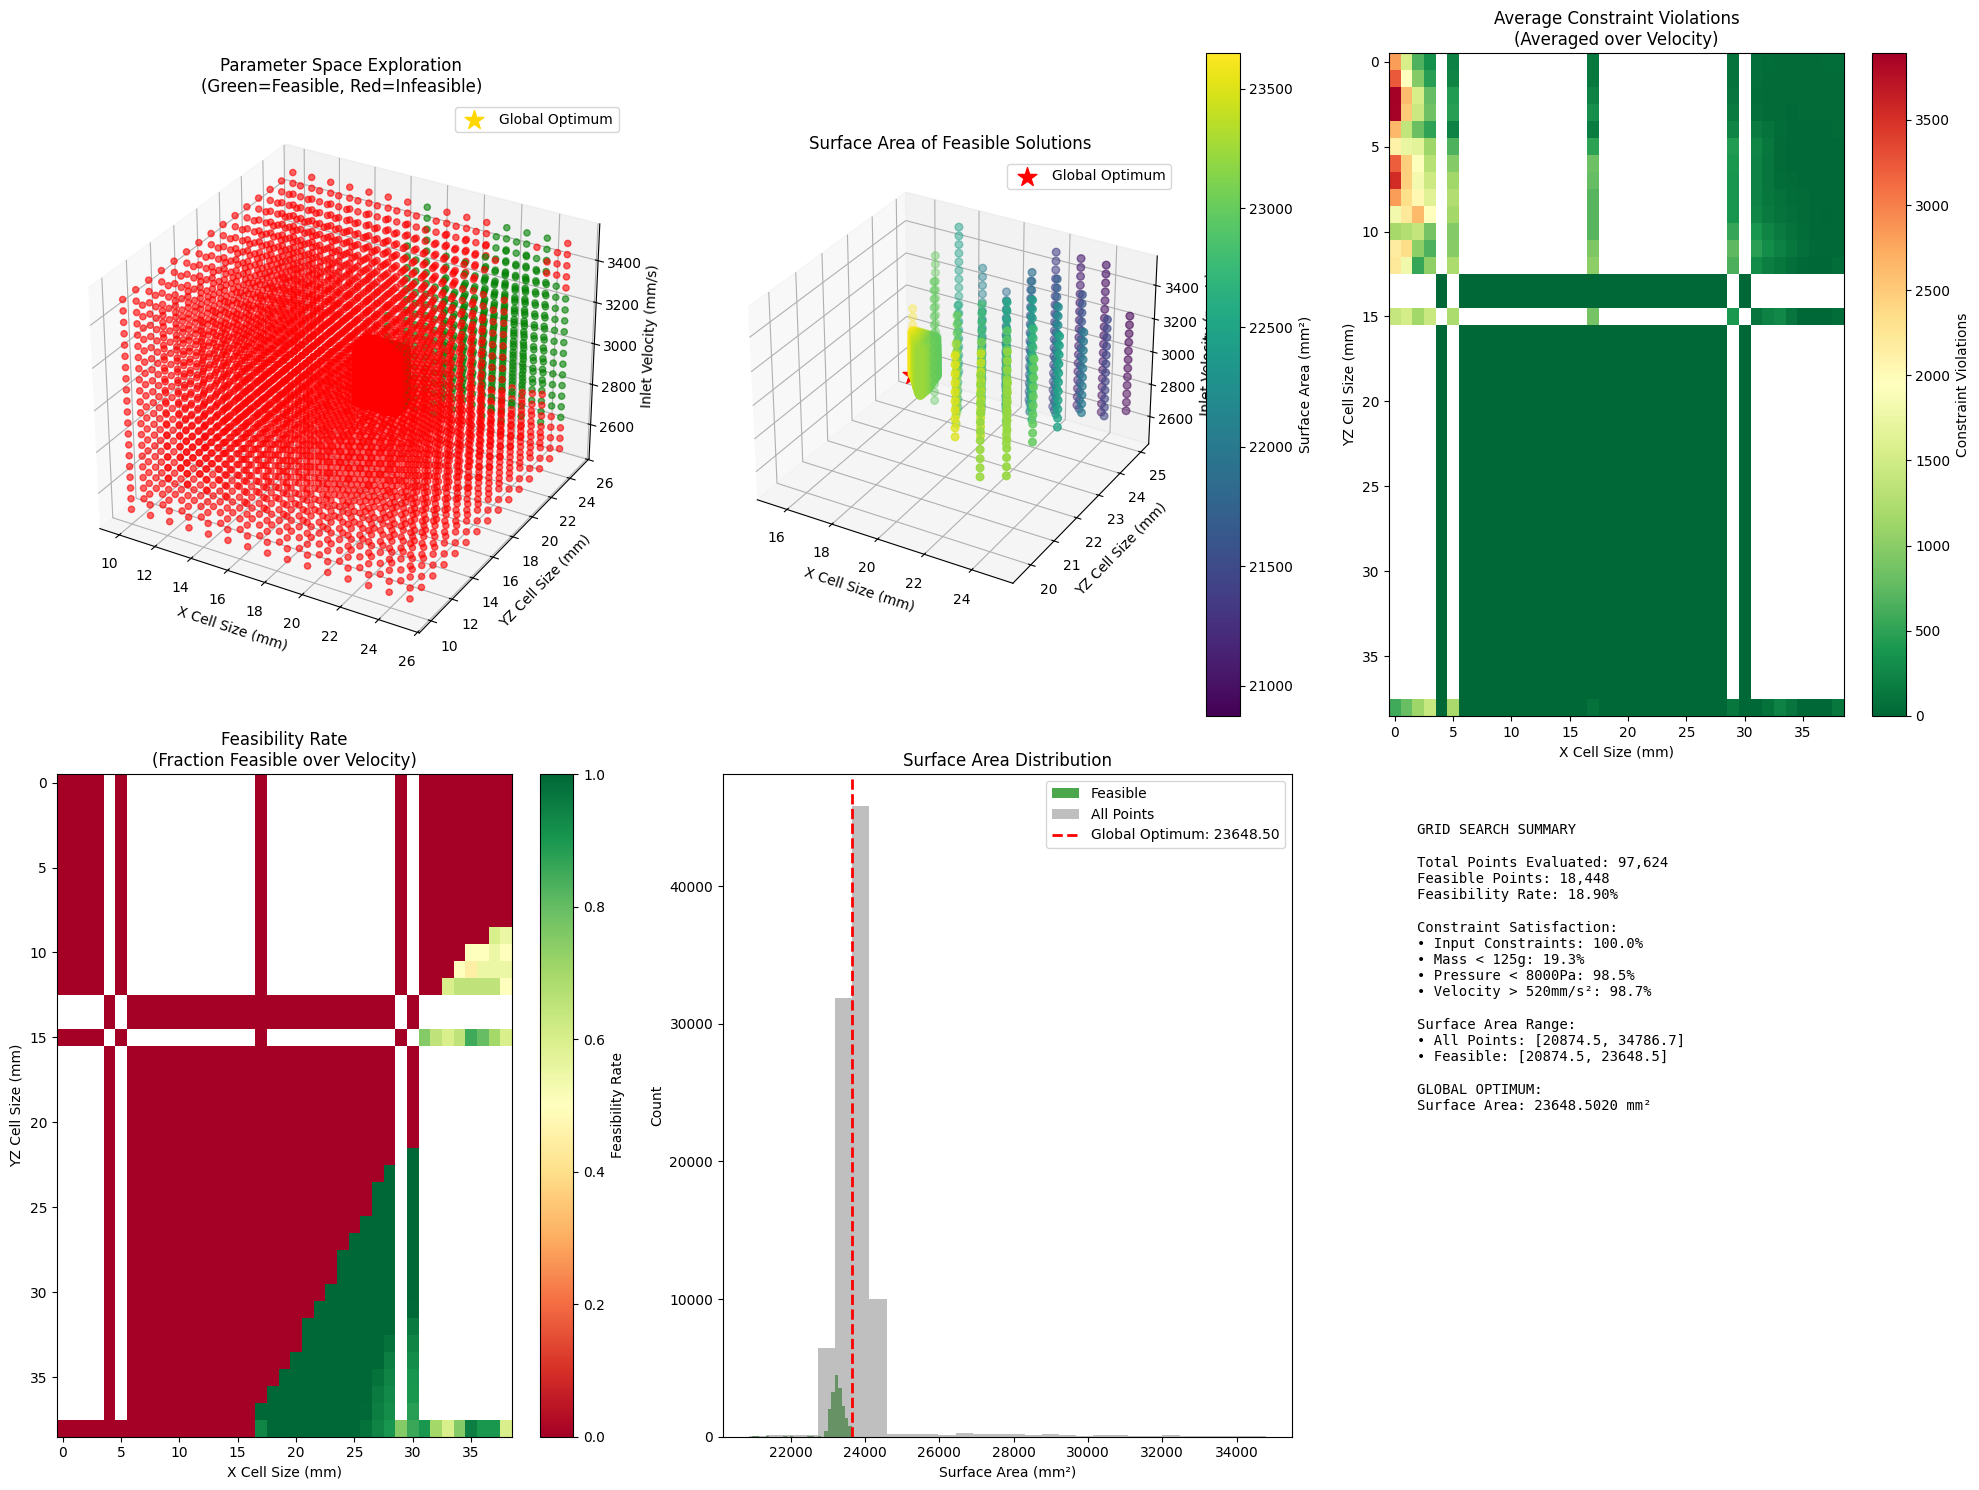

In [47]:
# Grid Search Optimization with Progressive Refinement
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import time

class GridSearchOptimizer:
    def __init__(self, model1, model2):
        self.model1 = model1
        self.model2 = model2
        self.all_results = []
        
    def evaluate_single_point(self, x_cell, yz_cell, v_inlet):
        """Evaluate a single parameter combination"""
        try:
            # Model 1 predictions
            m1_pred = self.model1.predict(x_cell, yz_cell)
            mass = m1_pred["mass"]
            surface_area = m1_pred["surface_area"]
            
            # Model 2 predictions
            m2_pred = self.model2.predict(x_cell, yz_cell, v_inlet)
            avg_velocity = m2_pred["avg_velocity"]
            pressure_drop = m2_pred["pressure_drop"]
            
            # Check constraints
            input_constraints = (10.0 <= x_cell <= 25.0 and 
                               10.0 <= yz_cell <= 25.0 and 
                               2500.0 <= v_inlet <= 3500.0)
            
            mass_ok = mass <= 125.0
            pressure_ok = pressure_drop <= 8000.0
            velocity_ok = avg_velocity >= 520.0
            
            all_feasible = input_constraints and mass_ok and pressure_ok and velocity_ok
            
            return {
                'x_cell': x_cell,
                'yz_cell': yz_cell,
                'v_inlet': v_inlet,
                'mass': mass,
                'surface_area': surface_area,
                'avg_velocity': avg_velocity,
                'pressure_drop': pressure_drop,
                'input_constraints_ok': input_constraints,
                'mass_ok': mass_ok,
                'pressure_ok': pressure_ok,
                'velocity_ok': velocity_ok,
                'all_feasible': all_feasible,
                'constraint_violations': max(0, mass - 125) + max(0, pressure_drop - 8000) + max(0, 520 - avg_velocity)
            }
            
        except Exception as e:
            print(f"Error evaluating point ({x_cell:.3f}, {yz_cell:.3f}, {v_inlet:.1f}): {e}")
            return None
    
    def coarse_grid_search(self, x_points=15, yz_points=15, v_points=20):
        """
        Stage 1: Coarse grid search across the entire parameter space
        """
        print("="*80)
        print("STAGE 1: COARSE GRID SEARCH")
        print("="*80)
        print(f"Grid resolution: {x_points} × {yz_points} × {v_points} = {x_points*yz_points*v_points:,} points")
        print("Parameter ranges:")
        print("  X Cell Size: [10.0, 25.0] mm")
        print("  YZ Cell Size: [10.0, 25.0] mm") 
        print("  Inlet Velocity: [2500, 3500] mm/s")
        print()
        
        # Create coarse grids
        x_grid = np.linspace(10.0, 25.0, x_points)
        yz_grid = np.linspace(10.0, 25.0, yz_points)
        v_grid = np.linspace(2500, 3500, v_points)
        
        results = []
        total_points = len(x_grid) * len(yz_grid) * len(v_grid)
        
        print(f"Evaluating {total_points:,} parameter combinations...")
        start_time = time.time()
        
        for i, x in enumerate(x_grid):
            for j, yz in enumerate(yz_grid):
                for k, v in enumerate(v_grid):
                    point_num = i * len(yz_grid) * len(v_grid) + j * len(v_grid) + k + 1
                    
                    if point_num % (total_points // 10) == 0:
                        elapsed = time.time() - start_time
                        print(f"  Progress: {point_num:,}/{total_points:,} ({100*point_num/total_points:.1f}%) - {elapsed:.1f}s elapsed")
                    
                    result = self.evaluate_single_point(x, yz, v)
                    if result:
                        results.append(result)
        
        elapsed = time.time() - start_time
        print(f"\n✅ Coarse grid search completed in {elapsed:.1f}s")
        print(f"Valid evaluations: {len(results):,}/{total_points:,}")
        
        # Convert to DataFrame for analysis
        df_coarse = pd.DataFrame(results)
        
        # Analysis
        feasible_df = df_coarse[df_coarse['all_feasible']]
        print(f"\n📊 COARSE GRID ANALYSIS:")
        print(f"  Total feasible points: {len(feasible_df):,}")
        print(f"  Feasibility rate: {len(feasible_df)/len(df_coarse)*100:.2f}%")
        
        if len(feasible_df) > 0:
            best_feasible = feasible_df.loc[feasible_df['surface_area'].idxmax()]
            print(f"  Best feasible surface area: {best_feasible['surface_area']:.2f} mm²")
            print(f"  Best feasible parameters: X={best_feasible['x_cell']:.3f}, YZ={best_feasible['yz_cell']:.3f}, V={best_feasible['v_inlet']:.1f}")
            
            # Constraint satisfaction rates
            print(f"\n🎯 CONSTRAINT SATISFACTION (across all points):")
            print(f"  Input constraints: {df_coarse['input_constraints_ok'].sum():,}/{len(df_coarse):,} ({df_coarse['input_constraints_ok'].mean()*100:.1f}%)")
            print(f"  Mass constraint: {df_coarse['mass_ok'].sum():,}/{len(df_coarse):,} ({df_coarse['mass_ok'].mean()*100:.1f}%)")
            print(f"  Pressure constraint: {df_coarse['pressure_ok'].sum():,}/{len(df_coarse):,} ({df_coarse['pressure_ok'].mean()*100:.1f}%)")
            print(f"  Velocity constraint: {df_coarse['velocity_ok'].sum():,}/{len(df_coarse):,} ({df_coarse['velocity_ok'].mean()*100:.1f}%)")
        
        self.coarse_results = df_coarse
        return df_coarse
    
    def identify_refinement_regions(self, df_coarse, top_k=5, region_size_pct=20):
        """
        Identify promising regions for refinement based on coarse grid results
        """
        print(f"\n" + "="*80)
        print("STAGE 2: IDENTIFYING REFINEMENT REGIONS")
        print("="*80)
        
        feasible_df = df_coarse[df_coarse['all_feasible']]
        
        if len(feasible_df) == 0:
            print("❌ No feasible points found in coarse search!")
            print("Will refine around best infeasible points instead...")
            
            # Use points with lowest constraint violations
            df_sorted = df_coarse.sort_values('constraint_violations')
            top_points = df_sorted.head(top_k)
        else:
            print(f"✅ Found {len(feasible_df)} feasible points")
            print("Will refine around top feasible points by surface area...")
            
            # Use top feasible points by surface area
            top_points = feasible_df.nlargest(top_k, 'surface_area')
        
        print(f"\nTop {len(top_points)} points for refinement:")
        for i, (_, point) in enumerate(top_points.iterrows()):
            feasible_status = "✅ Feasible" if point['all_feasible'] else f"❌ Violations: {point['constraint_violations']:.3f}"
            print(f"  #{i+1}: X={point['x_cell']:.3f}, YZ={point['yz_cell']:.3f}, V={point['v_inlet']:.1f}")
            print(f"       Surface Area: {point['surface_area']:.2f} mm² | {feasible_status}")
        
        # Define refinement regions around these points
        regions = []
        region_size = region_size_pct / 100
        
        for i, (_, point) in enumerate(top_points.iterrows()):
            # Calculate region bounds
            x_center, yz_center, v_center = point['x_cell'], point['yz_cell'], point['v_inlet']
            
            x_range = (25.0 - 10.0) * region_size / 2
            yz_range = (25.0 - 10.0) * region_size / 2  
            v_range = (3500 - 2500) * region_size / 2
            
            x_min = max(10.0, x_center - x_range)
            x_max = min(25.0, x_center + x_range)
            yz_min = max(10.0, yz_center - yz_range)
            yz_max = min(25.0, yz_center + yz_range)
            v_min = max(2500, v_center - v_range)
            v_max = min(3500, v_center + v_range)
            
            regions.append({
                'id': i+1,
                'center': (x_center, yz_center, v_center),
                'bounds': ((x_min, x_max), (yz_min, yz_max), (v_min, v_max)),
                'expected_surface_area': point['surface_area'],
                'is_feasible': point['all_feasible']
            })
            
            print(f"\nRegion #{i+1} bounds:")
            print(f"  X: [{x_min:.3f}, {x_max:.3f}] (width: {x_max-x_min:.3f})")
            print(f"  YZ: [{yz_min:.3f}, {yz_max:.3f}] (width: {yz_max-yz_min:.3f})")
            print(f"  V: [{v_min:.1f}, {v_max:.1f}] (width: {v_max-v_min:.1f})")
        
        return regions
    
    def fine_grid_search(self, regions, x_points=20, yz_points=20, v_points=25):
        """
        Stage 3: Fine grid search in promising regions
        """
        print(f"\n" + "="*80)
        print("STAGE 3: FINE GRID SEARCH IN PROMISING REGIONS")  
        print("="*80)
        print(f"Fine grid resolution: {x_points} × {yz_points} × {v_points} per region")
        
        all_fine_results = []
        
        for region in regions:
            print(f"\n🔍 Refining Region #{region['id']}...")
            (x_min, x_max), (yz_min, yz_max), (v_min, v_max) = region['bounds']
            
            # Create fine grids for this region
            x_fine = np.linspace(x_min, x_max, x_points)
            yz_fine = np.linspace(yz_min, yz_max, yz_points)
            v_fine = np.linspace(v_min, v_max, v_points)
            
            region_results = []
            total_points = len(x_fine) * len(yz_fine) * len(v_fine)
            print(f"  Evaluating {total_points:,} points in region #{region['id']}...")
            
            start_time = time.time()
            
            for i, x in enumerate(x_fine):
                for j, yz in enumerate(yz_fine):
                    for k, v in enumerate(v_fine):
                        result = self.evaluate_single_point(x, yz, v)
                        if result:
                            result['region_id'] = region['id']
                            region_results.append(result)
                            all_fine_results.append(result)
            
            elapsed = time.time() - start_time
            
            # Analyze this region
            region_df = pd.DataFrame(region_results)
            feasible_region = region_df[region_df['all_feasible']]
            
            print(f"  ✅ Region #{region['id']} completed in {elapsed:.1f}s")
            print(f"  Valid points: {len(region_df):,}")
            print(f"  Feasible points: {len(feasible_region):,}")
            
            if len(feasible_region) > 0:
                best_in_region = feasible_region.loc[feasible_region['surface_area'].idxmax()]
                print(f"  Best in region: Surface Area = {best_in_region['surface_area']:.3f} mm²")
                print(f"                  X={best_in_region['x_cell']:.6f}, YZ={best_in_region['yz_cell']:.6f}, V={best_in_region['v_inlet']:.2f}")
            else:
                print(f"  ❌ No feasible points in region #{region['id']}")
        
        # Convert all fine results to DataFrame
        if all_fine_results:
            df_fine = pd.DataFrame(all_fine_results)
            print(f"\n📊 COMBINED FINE GRID ANALYSIS:")
            print(f"  Total fine points evaluated: {len(df_fine):,}")
            
            feasible_fine = df_fine[df_fine['all_feasible']]
            print(f"  Total feasible fine points: {len(feasible_fine):,}")
            print(f"  Fine grid feasibility rate: {len(feasible_fine)/len(df_fine)*100:.3f}%")
            
            self.fine_results = df_fine
            return df_fine
        else:
            print("❌ No valid fine grid results!")
            return None
    
    def find_global_optimum(self, df_coarse, df_fine=None):
        """
        Combine coarse and fine results to find the global optimum
        """
        print(f"\n" + "="*80)
        print("STAGE 4: IDENTIFYING GLOBAL OPTIMUM")
        print("="*80)
        
        # Combine datasets
        all_data = [df_coarse]
        if df_fine is not None:
            all_data.append(df_fine)
        
        df_combined = pd.concat(all_data, ignore_index=True)
        
        # Remove duplicates (keep the one with highest precision)
        df_combined = df_combined.drop_duplicates(
            subset=['x_cell', 'yz_cell', 'v_inlet'], 
            keep='last'  # Keep fine grid results over coarse
        )
        
        print(f"Combined dataset: {len(df_combined):,} unique points")
        
        # Find feasible solutions
        feasible_combined = df_combined[df_combined['all_feasible']]
        
        if len(feasible_combined) > 0:
            # Sort by surface area
            feasible_sorted = feasible_combined.sort_values('surface_area', ascending=False)
            
            print(f"\n✅ FEASIBLE SOLUTIONS FOUND: {len(feasible_combined):,}")
            print(f"\n🏆 TOP 5 SOLUTIONS:")
            
            for i in range(min(5, len(feasible_sorted))):
                solution = feasible_sorted.iloc[i]
                print(f"\n#{i+1} Surface Area: {solution['surface_area']:.4f} mm²")
                print(f"    Parameters: X={solution['x_cell']:.6f}, YZ={solution['yz_cell']:.6f}, V={solution['v_inlet']:.3f}")
                print(f"    Performance: Mass={solution['mass']:.3f}g, PressureDrop={solution['pressure_drop']:.1f}Pa, AvgVel={solution['avg_velocity']:.1f}mm/s²")
            
            # Global optimum
            global_optimum = feasible_sorted.iloc[0]
            
            print(f"\n" + "="*60)
            print("🎯 GLOBAL OPTIMUM FOUND!")
            print("="*60)
            print(f"📋 OPTIMAL PARAMETERS FOR nTOP FILE:")
            print(f"   X Cell Size: {global_optimum['x_cell']:.8f}")
            print(f"   YZ Cell Size: {global_optimum['yz_cell']:.8f}")
            print(f"   Inlet Velocity: {global_optimum['v_inlet']:.5f}")
            print(f"\n🎯 MAXIMUM PERFORMANCE:")
            print(f"   Surface Area: {global_optimum['surface_area']:.4f} mm² ⭐")
            print(f"   Mass: {global_optimum['mass']:.4f} grams (< 125 ✅)")
            print(f"   Pressure Drop: {global_optimum['pressure_drop']:.2f} Pa (< 8000 ✅)")
            print(f"   Average Velocity: {global_optimum['avg_velocity']:.2f} mm/s² (> 520 ✅)")
            print("="*60)
            
            return global_optimum, feasible_sorted
            
        else:
            print("❌ NO GLOBALLY FEASIBLE SOLUTION FOUND")
            
            # Find best infeasible solutions
            df_sorted_by_violations = df_combined.sort_values(['constraint_violations', 'surface_area'], ascending=[True, False])
            
            print(f"\n🔍 BEST INFEASIBLE ATTEMPTS:")
            for i in range(min(5, len(df_sorted_by_violations))):
                solution = df_sorted_by_violations.iloc[i]
                print(f"\n#{i+1} Constraint Violations: {solution['constraint_violations']:.4f}")
                print(f"    Surface Area: {solution['surface_area']:.4f} mm²")
                print(f"    Parameters: X={solution['x_cell']:.6f}, YZ={solution['yz_cell']:.6f}, V={solution['v_inlet']:.3f}")
                print(f"    Constraint Status: Mass {'✅' if solution['mass_ok'] else '❌'}, Pressure {'✅' if solution['pressure_ok'] else '❌'}, Velocity {'✅' if solution['velocity_ok'] else '❌'}")
            
            return df_sorted_by_violations.iloc[0], df_sorted_by_violations
    
    def visualize_results(self, df_coarse, df_fine=None, global_optimum=None):
        """Create comprehensive visualizations of the grid search results"""
        
        # Combine datasets for visualization
        if df_fine is not None:
            df_combined = pd.concat([df_coarse, df_fine], ignore_index=True)
            df_combined = df_combined.drop_duplicates(subset=['x_cell', 'yz_cell', 'v_inlet'], keep='last')
        else:
            df_combined = df_coarse
            
        feasible_df = df_combined[df_combined['all_feasible']]
        
        # Create figure with subplots
        fig = plt.figure(figsize=(20, 15))
        
        # 1. 3D Scatter plot of all points colored by feasibility
        ax1 = fig.add_subplot(2, 3, 1, projection='3d')
        colors = ['red' if not feasible else 'green' for feasible in df_combined['all_feasible']]
        scatter = ax1.scatter(df_combined['x_cell'], df_combined['yz_cell'], df_combined['v_inlet'], 
                            c=colors, alpha=0.6, s=20)
        ax1.set_xlabel('X Cell Size (mm)')
        ax1.set_ylabel('YZ Cell Size (mm)')
        ax1.set_zlabel('Inlet Velocity (mm/s)')
        ax1.set_title('Parameter Space Exploration\n(Green=Feasible, Red=Infeasible)')
        
        # Mark global optimum if found
        if global_optimum is not None:
            ax1.scatter([global_optimum['x_cell']], [global_optimum['yz_cell']], [global_optimum['v_inlet']], 
                       c='gold', s=200, marker='*', label='Global Optimum')
            ax1.legend()
        
        # 2. Surface Area vs Parameters (feasible points only)
        if len(feasible_df) > 0:
            ax2 = fig.add_subplot(2, 3, 2, projection='3d')
            scatter2 = ax2.scatter(feasible_df['x_cell'], feasible_df['yz_cell'], feasible_df['v_inlet'], 
                                 c=feasible_df['surface_area'], cmap='viridis', s=30)
            ax2.set_xlabel('X Cell Size (mm)')
            ax2.set_ylabel('YZ Cell Size (mm)')
            ax2.set_zlabel('Inlet Velocity (mm/s)')
            ax2.set_title('Surface Area of Feasible Solutions')
            plt.colorbar(scatter2, ax=ax2, label='Surface Area (mm²)')
            
            if global_optimum is not None:
                ax2.scatter([global_optimum['x_cell']], [global_optimum['yz_cell']], [global_optimum['v_inlet']], 
                           c='red', s=200, marker='*', label='Global Optimum')
                ax2.legend()
        
        # 3. Constraint violation heatmap
        ax3 = fig.add_subplot(2, 3, 3)
        constraint_data = df_combined.pivot_table(values='constraint_violations', 
                                                 index='yz_cell', columns='x_cell', aggfunc='mean')
        im3 = ax3.imshow(constraint_data.values, cmap='RdYlGn_r', aspect='auto')
        ax3.set_xlabel('X Cell Size (mm)')
        ax3.set_ylabel('YZ Cell Size (mm)')
        ax3.set_title('Average Constraint Violations\n(Averaged over Velocity)')
        plt.colorbar(im3, ax=ax3, label='Constraint Violations')
        
        # 4. Feasibility rate by parameters
        ax4 = fig.add_subplot(2, 3, 4)
        feasibility_data = df_combined.pivot_table(values='all_feasible', 
                                                  index='yz_cell', columns='x_cell', aggfunc='mean')
        im4 = ax4.imshow(feasibility_data.values, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
        ax4.set_xlabel('X Cell Size (mm)')
        ax4.set_ylabel('YZ Cell Size (mm)')
        ax4.set_title('Feasibility Rate\n(Fraction Feasible over Velocity)')
        plt.colorbar(im4, ax=ax4, label='Feasibility Rate')
        
        # 5. Surface area distribution
        ax5 = fig.add_subplot(2, 3, 5)
        if len(feasible_df) > 0:
            ax5.hist(feasible_df['surface_area'], bins=30, alpha=0.7, color='green', label='Feasible')
        ax5.hist(df_combined['surface_area'], bins=30, alpha=0.5, color='gray', label='All Points')
        ax5.set_xlabel('Surface Area (mm²)')
        ax5.set_ylabel('Count')
        ax5.set_title('Surface Area Distribution')
        ax5.legend()
        
        if global_optimum is not None:
            ax5.axvline(global_optimum['surface_area'], color='red', linestyle='--', linewidth=2, 
                       label=f'Global Optimum: {global_optimum["surface_area"]:.2f}')
            ax5.legend()
        
        # 6. Summary statistics
        ax6 = fig.add_subplot(2, 3, 6)
        ax6.axis('off')
        
        # Create summary text
        total_points = len(df_combined)
        feasible_points = len(feasible_df)
        feasibility_rate = feasible_points / total_points * 100
        
        summary_text = f"""
GRID SEARCH SUMMARY

Total Points Evaluated: {total_points:,}
Feasible Points: {feasible_points:,}
Feasibility Rate: {feasibility_rate:.2f}%

Constraint Satisfaction:
• Input Constraints: {df_combined['input_constraints_ok'].mean()*100:.1f}%
• Mass < 125g: {df_combined['mass_ok'].mean()*100:.1f}%
• Pressure < 8000Pa: {df_combined['pressure_ok'].mean()*100:.1f}%  
• Velocity > 520mm/s²: {df_combined['velocity_ok'].mean()*100:.1f}%

Surface Area Range:
• All Points: [{df_combined['surface_area'].min():.1f}, {df_combined['surface_area'].max():.1f}]
"""
        
        if len(feasible_df) > 0:
            summary_text += f"• Feasible: [{feasible_df['surface_area'].min():.1f}, {feasible_df['surface_area'].max():.1f}]"
            
        if global_optimum is not None:
            summary_text += f"\n\nGLOBAL OPTIMUM:\nSurface Area: {global_optimum['surface_area']:.4f} mm²"
        
        ax6.text(0.05, 0.95, summary_text, transform=ax6.transAxes, fontsize=10, 
                verticalalignment='top', fontfamily='monospace')
        
        plt.tight_layout()
        plt.show()
        
        return fig

def run_complete_grid_search(m1, m2, coarse_resolution=(15, 15, 20), fine_resolution=(25, 25, 30)):
    """
    Run the complete multi-stage grid search optimization
    """
    print("🔍 COMPREHENSIVE GRID SEARCH OPTIMIZATION")
    print("This will systematically explore the entire parameter space")
    print("and refine around promising regions for the exact global optimum.")
    
    optimizer = GridSearchOptimizer(m1, m2)
    
    # Stage 1: Coarse grid search
    df_coarse = optimizer.coarse_grid_search(
        x_points=coarse_resolution[0], 
        yz_points=coarse_resolution[1], 
        v_points=coarse_resolution[2]
    )
    
    # Stage 2: Identify refinement regions
    regions = optimizer.identify_refinement_regions(df_coarse, top_k=5, region_size_pct=15)
    
    # Stage 3: Fine grid search
    df_fine = optimizer.fine_grid_search(
        regions, 
        x_points=fine_resolution[0],
        yz_points=fine_resolution[1], 
        v_points=fine_resolution[2]
    )
    
    # Stage 4: Find global optimum
    global_optimum, all_solutions = optimizer.find_global_optimum(df_coarse, df_fine)
    
    # Stage 5: Visualize results
    print(f"\n" + "="*80)
    print("STAGE 5: GENERATING VISUALIZATIONS")
    print("="*80)
    optimizer.visualize_results(df_coarse, df_fine, global_optimum)
    
    return {
        'optimizer': optimizer,
        'coarse_results': df_coarse,
        'fine_results': df_fine,
        'global_optimum': global_optimum,
        'all_solutions': all_solutions,
        'refinement_regions': regions
    }

# Integration with existing workflow
def main_with_grid_search():
    """Complete pipeline with grid search optimization"""
    print("Training models...")
    m1, m2 = main()
    
    print(f"\n" + "🎯"*40)
    print("STARTING COMPREHENSIVE GRID SEARCH")
    print("🎯"*40)
    
    # Run grid search with different resolution options
    print("\nChoose resolution level:")
    print("1. Quick (coarse: 10×10×15, fine: 15×15×20) - ~5 minutes")
    print("2. Standard (coarse: 15×15×20, fine: 25×25×30) - ~15 minutes") 
    print("3. High (coarse: 20×20×25, fine: 35×35×40) - ~45 minutes")
    print("4. Ultra (coarse: 25×25×30, fine: 50×50×60) - ~2 hours")
    
    # For automatic execution, use Standard
    resolution_configs = {
        1: ((10, 10, 15), (15, 15, 20)),
        2: ((15, 15, 20), (25, 25, 30)),  # Default
        3: ((20, 20, 25), (35, 35, 40)),
        4: ((25, 25, 30), (50, 50, 60))
    }
    
    # Use standard resolution by default
    coarse_res, fine_res = resolution_configs[2]
    
    print(f"Using Standard resolution: Coarse {coarse_res}, Fine {fine_res}")
    
    results = run_complete_grid_search(m1, m2, coarse_res, fine_res)
    
    return m1, m2, results

# Example usage:
if __name__ == "__main__":
    # Run complete grid search optimization
    m1, m2, grid_results = main_with_grid_search()